# Subscriber Cancellations Data Pipeline 

## Discovery work in Jupyter

Explore and clean dataframes (NaNs, duplicates, dtypes, column format, useful columns...)

Project aim: Create a data ingestion pipeline in Python to automatically clean and update a customer information databse. In addition to cleaning and updating the data, we’ll automate the updating process using error logging and bash scripting.

In [1]:
import sqlite3
import pandas as pd
import ast
import numpy as np
import os

In [2]:
os.chdir('/Users/Leo/Documents/coding_projects/Code Academy projects/subscriber-pipeline-starter-kit/dev')

In [3]:
# Establish connection with db
con = sqlite3.connect('cademycode.db')
cur = con.cursor()

In [4]:
# Schema
table_list = [t for t in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_list

[('cademycode_students',),
 ('cademycode_courses',),
 ('cademycode_student_jobs',)]

In [5]:
# Load data in to pandas df
students = pd.read_sql_query("SELECT * FROM cademycode_students", con)
career_path = pd.read_sql_query("SELECT * FROM cademycode_courses", con)
student_jobs = pd.read_sql_query("SELECT * FROM cademycode_student_jobs", con)

In [6]:
# Close db connection 
con.close()

## Students DataFrame

In [7]:
students.head(3)

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74


In [8]:
students.isna().sum()

uuid                        0
name                        0
dob                         0
sex                         0
contact_info                0
job_id                      5
num_course_taken          251
current_career_path_id    471
time_spent_hrs            471
dtype: int64

In [9]:
students.dtypes

uuid                       int64
name                      object
dob                       object
sex                       object
contact_info              object
job_id                    object
num_course_taken          object
current_career_path_id    object
time_spent_hrs            object
dtype: object

### Age

In [10]:
# Calculate Age (more usefule than date of birth)
#today_date = pd.to_datetime('now')
today_date = pd.to_datetime('now',utc=True)

students['age'] = (today_date - pd.to_datetime(students['dob'],utc=True)).astype('<m8[Y]')
students['age_group'] = students['age'].apply(lambda x: np.floor(x / 10) * 10)

In [11]:
# Sort out `contact_info` currently stored in an usuable format
print(students['contact_info'][0])

{"mailing_address": "303 N Timber Key, Irondale, Wisconsin, 84736", "email": "annabelle_avery9376@woohoo.com"}


In [12]:
type(students['contact_info'][0])

str

The `contact_info` data looks like it's stored as a dictinary, but it's actually a string. So we'll use the `ast` library to evalute the strings and convert them to dictionaries. From there we'can use pandas `.jason_normalise` to extract the data:

In [13]:
students['contact_info'] = students["contact_info"].apply(lambda x: ast.literal_eval(str(x)))
explode_contact = pd.json_normalize(students['contact_info'])
students = pd.concat([students, explode_contact], axis=1)
students = students.drop('contact_info', axis=1).reset_index(drop=True)

### Mailing address

In [14]:
# Split the address line
split_address = students['mailing_address'].str.split(',', expand=True)
split_address.columns = ['street', 'city', 'state', 'zipcode']
students = pd.concat([students,split_address], axis=1)
students = students.drop('mailing_address', axis=1).reset_index(drop=True)

Check that the colmuns have been created correctly and that no *NaNs* were genereated (e.g., if some emails where missing)

In [15]:
students.head(3)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zipcode
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,80.0,80.0,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,32.0,30.0,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,33.0,30.0,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637


In [16]:
students.isna().sum()

uuid                        0
name                        0
dob                         0
sex                         0
job_id                      5
num_course_taken          251
current_career_path_id    471
time_spent_hrs            471
age                         0
age_group                   0
email                       0
street                      0
city                        0
state                       0
zipcode                     0
dtype: int64

### Ensure data types are appropriate

In [17]:
students[['job_id', 'num_course_taken','current_career_path_id', 'time_spent_hrs']] = \
    students[['job_id', 'num_course_taken','current_career_path_id', 'time_spent_hrs']].astype(float)

### Contact Info

In [18]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    5000 non-null   int64  
 1   name                    5000 non-null   object 
 2   dob                     5000 non-null   object 
 3   sex                     5000 non-null   object 
 4   job_id                  4995 non-null   float64
 5   num_course_taken        4749 non-null   float64
 6   current_career_path_id  4529 non-null   float64
 7   time_spent_hrs          4529 non-null   float64
 8   age                     5000 non-null   float64
 9   age_group               5000 non-null   float64
 10  email                   5000 non-null   object 
 11  street                  5000 non-null   object 
 12  city                    5000 non-null   object 
 13  state                   5000 non-null   object 
 14  zipcode                 5000 non-null   

### Handle NaNs

Three columns to look at: 
* `job_id`
* `num_course_taken`
* `current_career_path_id` 
* `time_spent_hrs`

We'll drop the rows that are missing at random and store that data in **missing_data**

In [19]:
# Missing data
missing_data = pd.DataFrame()

In [20]:
# Job ID
missing_job_id = students[students['job_id'].isna()] 
missing_job_id

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zipcode
162,163,Glen Riley,2002-08-22,M,NaN,8.0,3.0,5.70,21.0,20.0,glen_riley4484@hmail.com,P.O. Box 37267,Cornlea village,Tennessee,19192
757,758,Mercedez Vorberg,2002-03-25,F,NaN,15.0,4.0,4.14,21.0,20.0,mercedez6297@woohoo.com,284 Cedar Seventh,Virden village,Washington,60489
854,855,Kurt Ho,2002-05-29,M,NaN,0.0,8.0,23.72,21.0,20.0,ho6107@inlook.com,P.O. Box 27254,Olin,New Hampshire,60067
1029,1030,Penny Gaines,2002-03-01,N,NaN,15.0,4.0,16.25,21.0,20.0,gaines2897@hmail.com,138 Misty Vale,Stockton borough,West Virginia,53630
1542,1543,Frederick Reilly,2002-11-13,M,NaN,7.0,9.0,21.32,21.0,20.0,frederick_reilly6971@woohoo.com,P.O. Box 40769,Quakervillage,Maryland,96218


In [21]:
missing_data = pd.concat([missing_data,missing_job_id])
students = students.dropna(subset='job_id')

Only 5 rows missing with link to other missing columns - we'll remove them.

In [22]:
# Number of Course Taken 
missing_course_taken = students[students['num_course_taken'].isna()]
missing_course_taken

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zipcode
25,26,Doug Browning,1970-06-08,M,7.0,NaN,5.0,1.92,53.0,50.0,doug7761@inlook.com,P.O. Box 15845,Devine,Florida,23097
26,27,Damon Schrauwen,1953-10-31,M,4.0,NaN,10.0,3.73,70.0,70.0,damon9864@woohoo.com,P.O. Box 84659,Maben,Georgia,66137
51,52,Alisa Neil,1977-05-28,F,5.0,NaN,8.0,22.86,46.0,40.0,alisa9616@inlook.com,16 View Annex,Mosses,North Dakota,25748
70,71,Chauncey Hooper,1962-04-07,M,3.0,NaN,3.0,3.97,61.0,60.0,chauncey6352@woohoo.com,955 Dewy Flat,Slaughterville,South Carolina,22167
80,81,Ellyn van Heest,1984-06-28,F,3.0,NaN,10.0,12.39,39.0,30.0,ellyn_vanheest8375@hmail.com,872 Cider Glade,Chicken,Delaware,42689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,4890,Tegan Cochran,1970-11-08,F,5.0,NaN,8.0,22.75,53.0,50.0,tegan130@inlook.com,106 Sunny Nook,Vernal,Georgia,10769
4898,4899,Ruthann Oliver,1998-05-22,F,3.0,NaN,7.0,21.27,25.0,20.0,ruthann1124@woohoo.com,644 Merry Island,Green Valley,Wyoming,91273
4914,4915,Ernest Holmes,1995-03-11,M,7.0,NaN,9.0,26.50,28.0,20.0,ernest_holmes505@hmail.com,872 Wintergreen Harbor,Gallitzin borough,Maine,50103
4980,4981,Brice Franklin,1946-12-01,M,4.0,NaN,5.0,8.66,77.0,70.0,brice9741@coldmail.com,947 Panda Way,New Bedford village,Vermont,31232


Let's assess whether the missing data is associated to any other column by comparing percentages

<Axes: xlabel='sex'>

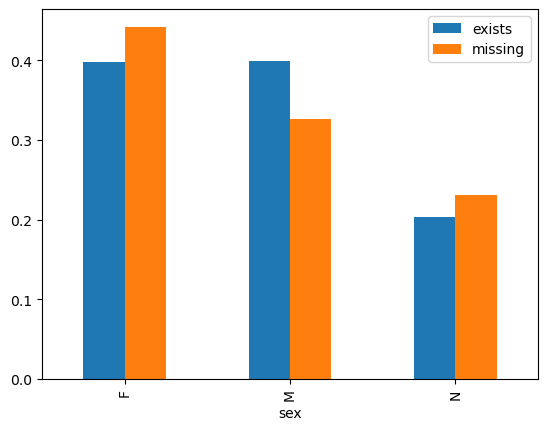

In [23]:
exists = (students.groupby('sex').count()['uuid']/len(students)).rename("exists")
missing = (missing_course_taken.groupby('sex').count()['uuid']/len(missing_course_taken)).rename("missing")

df_assess = pd.concat([exists,missing], axis=1)
df_assess.plot.bar()

<Axes: xlabel='job_id'>

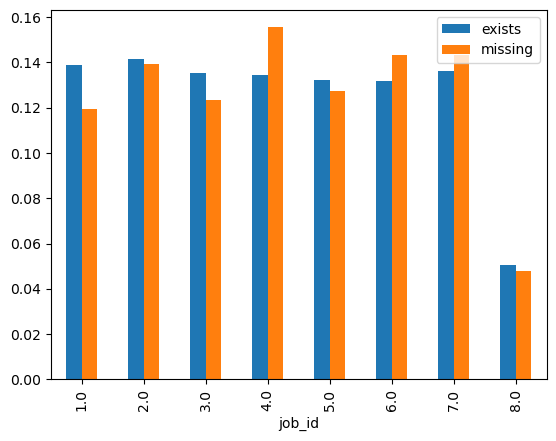

In [24]:
exists = (students.groupby('job_id').count()['uuid']/len(students)).rename("exists")
missing = (missing_course_taken.groupby('job_id').count()['uuid']/len(missing_course_taken)).rename("missing")

df_assess = pd.concat([exists,missing], axis=1)
df_assess.plot.bar()

<Axes: xlabel='age_group'>

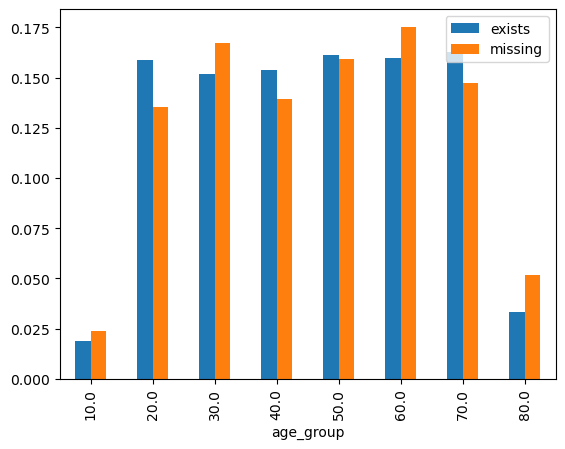

In [25]:
exists = (students.groupby('age_group').count()['uuid']/len(students)).rename("exists")
missing = (missing_course_taken.groupby('age_group').count()['uuid']/len(missing_course_taken)).rename("missing")

df_assess = pd.concat([exists,missing], axis=1)
df_assess.plot.bar()

In all cases, no clear correlation with the missing data (never more than a couple of %). We'll remove the data

In [26]:
missing_data = pd.concat([missing_data, missing_course_taken])
students = students.dropna(subset=['num_course_taken'])

In [27]:
# Current Career Path ID and Hours Spent
missing_path_id = students[students['current_career_path_id'].isna()] 
missing_path_id

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zipcode
15,16,Norene Dalton,1976-04-30,F,6.0,0.0,NaN,NaN,47.0,40.0,norene_dalton9509@hmail.com,130 Wishing Essex,Branch,Ohio,13616
19,20,Sofia van Steenbergen,1990-02-21,N,7.0,13.0,NaN,NaN,33.0,30.0,vansteenbergen8482@inlook.com,634 Clear Barn Dell,Beaman,Georgia,33288
30,31,Christoper Warner,1989-12-28,M,2.0,5.0,NaN,NaN,33.0,30.0,warner5906@coldmail.com,556 Stony Highlands,Drain,Illinois,01973
49,50,Antony Horne,1996-05-29,M,3.0,2.0,NaN,NaN,27.0,20.0,antony577@coldmail.com,P.O. Box 78685,Lenox,Texas,15516
54,55,Omar Bunk,1955-11-08,M,3.0,14.0,NaN,NaN,68.0,60.0,omar1245@coldmail.com,445 Dale Hollow,Vermont village,South Carolina,28329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,4905,Eduardo Daniel,2004-06-18,M,8.0,12.0,NaN,NaN,19.0,10.0,daniel5073@inlook.com,598 Deer Trace,Forest Grove,North Carolina,45038
4922,4923,Francisco van Ede,1961-04-26,M,7.0,5.0,NaN,NaN,62.0,60.0,vanede7845@coldmail.com,282 Fourth Trace,Carter Lake,Ohio,63511
4948,4949,Dewitt van Malsem,1949-03-08,M,4.0,7.0,NaN,NaN,74.0,70.0,dewitt4635@inlook.com,423 Course Trail,Wilmot,Hawaii,18996
4956,4957,Todd Stamhuis,1961-06-15,M,7.0,8.0,NaN,NaN,62.0,60.0,todd8019@woohoo.com,251 Grand Rose Underpass,Niagara,Pennsylvania,03430


In [28]:
missing_path_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451 entries, 15 to 4974
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    451 non-null    int64  
 1   name                    451 non-null    object 
 2   dob                     451 non-null    object 
 3   sex                     451 non-null    object 
 4   job_id                  451 non-null    float64
 5   num_course_taken        451 non-null    float64
 6   current_career_path_id  0 non-null      float64
 7   time_spent_hrs          0 non-null      float64
 8   age                     451 non-null    float64
 9   age_group               451 non-null    float64
 10  email                   451 non-null    object 
 11  street                  451 non-null    object 
 12  city                    451 non-null    object 
 13  state                   451 non-null    object 
 14  zipcode                 451 non-null    

It's very likely that the data is structuraly missing as whenever `time_spent_hrs` is missing, `current_career_path_id` is too (which makes sense). We'll set both to 0 when missing to identify that a student hasn't enrolled in a career path course.

In [29]:
students['current_career_path_id'].unique()

array([ 1.,  8.,  9.,  3.,  6., 10.,  5., nan,  4.,  7.,  2.])

In [30]:
students['current_career_path_id'] = np.where(students['current_career_path_id'].isna(), 0,
                                              students['current_career_path_id'])
students['time_spent_hrs'] = np.where(students['time_spent_hrs'].isna(), 0, students['time_spent_hrs'])


In [31]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   age_group               4744 non-null   float64
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zipcode                 4744 non-null   

## Course DataFrame

In [32]:
career_path

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


In [33]:
career_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   career_path_id     10 non-null     int64 
 1   career_path_name   10 non-null     object
 2   hours_to_complete  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 368.0+ bytes


### Adding the "0" career path (i.e., not enrolled in a career path course)

In [34]:
# Adding the "0" career path we've added in student into this dataframe
no_career_path = {'career_path_id': 0,
                  'career_path_name': 'not applicable',
                  'hours_to_complete' : 0}

career_path.iloc[-1] = no_career_path

career_path

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,0,not applicable,0


## Students Job DataFrame

In [35]:
student_jobs

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


In [36]:
student_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_id        13 non-null     int64 
 1   job_category  13 non-null     object
 2   avg_salary    13 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 440.0+ bytes


In [37]:
# Drop duplicates
student_jobs.drop_duplicates(inplace=True)
student_jobs

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


## Load the clean table into: database_cleansed

In [38]:
con = sqlite3.connect('cademycode_cleansed.db')

In [39]:
students.to_sql('students', con, if_exists='replace', index=False)
career_path.to_sql('career_path', con, if_exists='replace', index=False)
student_jobs.to_sql('student_jobs', con, if_exists='replace', index=False)
missing_data.to_sql('missing_data', con, if_exists='replace', index=False)

256

Sanity checks:

In [40]:
db_students_df = pd.read_sql_query("SELECT * FROM students", con)
db_students_df

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zipcode
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,80.0,80.0,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.40,32.0,30.0,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,33.0,30.0,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,35.0,30.0,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,60.0,60.0,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4739,4996,Quentin van Harn,1967-07-07,N,5.0,5.0,2.0,13.82,56.0,50.0,vanharn2778@woohoo.com,591 Blue Berry,Coulee,Illinois,65199
4740,4997,Alejandro van der Sluijs,1964-11-03,M,4.0,13.0,1.0,7.86,59.0,50.0,alejandro4080@coldmail.com,30 Iron Divide,Pewaukee village,California,62992
4741,4998,Brock Mckenzie,2004-11-25,M,8.0,10.0,3.0,12.10,19.0,10.0,brock_mckenzie2025@inlook.com,684 Rustic Rest Avenue,Carmine,California,55657
4742,4999,Donnetta Dillard,1943-02-12,N,3.0,6.0,5.0,14.86,80.0,80.0,dillard7526@inlook.com,900 Indian Oval,Euclid,Iowa,59683


In [41]:
con.close()